### Importing the Dataset

In [ ]:
#Object detection using Transfer Learning of CNN architectures
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

### Load images and labels

In [ ]:
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


### Image processiong

In [ ]:
# checking existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [ ]:
# resizing the image
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [ ]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0])>

In [ ]:
# transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

### Using pretrained VGG16 Image Classification model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# loading VGG16 model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=train_ds[0].shape
)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# Preprocessing Input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Add our own layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5, restore_best_weights=True
)

In [ ]:
h = model.fit(
    train_ds,
    train_labels,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/10
65/65 [==============================] - 1903s 29s/step - loss: 3.8665 - accuracy: 0.2195 - val_loss: 1.6085 - val_accuracy: 0.2490
Epoch 2/10
65/65 [==============================] - 1866s 29s/step - loss: 1.6087 - accuracy: 0.2418 - val_loss: 1.6075 - val_accuracy: 0.2490
Epoch 3/10
65/65 [==============================] - 1870s 29s/step - loss: 1.6053 - accuracy: 0.2487 - val_loss: 1.6064 - val_accuracy: 0.2490
Epoch 4/10
65/65 [==============================] - 1871s 29s/step - loss: 1.6040 - accuracy: 0.2487 - val_loss: 1.6060 - val_accuracy: 0.2490
Epoch 5/10
65/65 [==============================] - 1894s 29s/step - loss: 1.6029 - accuracy: 0.2487 - val_loss: 1.6056 - val_accuracy: 0.2490
Epoch 6/10
65/65 [==============================] - 1905s 29s/step - loss: 1.6019 - accuracy: 0.2487 - val_loss: 1.6053 - val_accuracy: 0.2490


In [ ]:
loss, accuracy = model.evaluate(test_ds, test_labels)
print("Loss: ", loss, "Accuracy: ", accuracy)

35/35 [==============================] - 268s 8s/step - loss: 1.6075 - accuracy: 0.2589
Loss:  1.6075022220611572 Accuracy:  0.25885558128356934


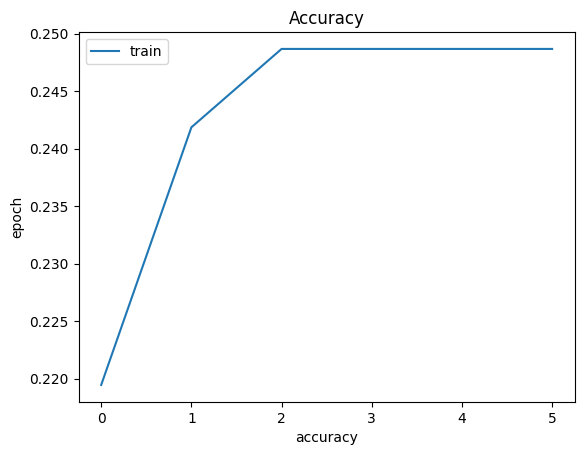

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train'])
plt.show()

In [ ]:
import numpy as np
import pandas as pd
y_pred = model.predict(test_ds)
y_classes = [np.argmax(element) for element in y_pred]
#to_categorical(y_classes, num_classes=5)
#to_categorical(test_labels, num_classes=5)
print(y_classes[:10])
print("\nTest")
print(test_labels[:10])

35/35 [==============================] - 267s 8s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Test
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
